# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Import Required Libraries 📚</h1></span>

In [1]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision

import torchmetrics

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict, Counter

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Configuration ⚙️</h1></span>

In [2]:
CONFIG = {
    "seed": 42,
    "epochs": 30,
    "img_size": 2048,
    "model_name": "tf_efficientnet_b0_ns",
    "pretrained" : "/kaggle/input/ubc-finetune-cnn-without-thumbnails/Recall0.8726_Acc0.9067_Loss0.2489_epoch3.bin",
    "label_pkl" : "/kaggle/input/ubc-finetune-cnn-without-thumbnails/label_encoder.pkl",
    "num_classes": 5,
    "train_batch_size": 2,
    "valid_batch_size": 4,
    "learning_rate": 2e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Set Seed for Reproducibility</h1></span>

In [3]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [4]:
ROOT_DIR = '/kaggle/input/ubc-crop-training-raw-images'
TEST_DIR = '/kaggle/input/UBC-OCEAN/test_images'

# <h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Read the Data 📖</h1>

In [5]:
df_ori = pd.read_csv("/kaggle/input/UBC-OCEAN/train.csv")
df_ori.head()

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False


In [6]:
tma_image_id = df_ori[df_ori["is_tma"] == True]["image_id"].values

In [7]:
df = pd.read_csv(f"{ROOT_DIR}/train.csv")
df = df[df["image_id"].isin(tma_image_id)].reset_index()
df["file_path"] = df["file_path"].apply(lambda x: f"{ROOT_DIR}/{x}" )
df.head()

,index,sx,ex,sy,ey,image_id,label,ori_width,ori_height,crop_id,file_path,weight
0,2,0,2047,0,2047,91,HGSC,2048,2048,0,/kaggle/input/ubc-crop-training-raw-images/ima...,0.999024
1,57,0,2047,0,2047,4134,MC,2048,2048,0,/kaggle/input/ubc-crop-training-raw-images/ima...,0.999024
2,113,0,2047,0,2047,8280,HGSC,2048,2048,0,/kaggle/input/ubc-crop-training-raw-images/ima...,0.999024
3,123,0,2047,0,2047,9200,MC,2048,2048,0,/kaggle/input/ubc-crop-training-raw-images/ima...,0.999024
4,162,0,2047,0,2047,13568,LGSC,2048,2048,0,/kaggle/input/ubc-crop-training-raw-images/ima...,0.999024


In [8]:
df["label"].unique()

array(['HGSC', 'MC', 'LGSC', 'EC', 'CC'], dtype=object)

In [9]:
encoder = joblib.load(CONFIG["label_pkl"]) 

In [10]:
df['label_str'] = df['label']
df_ori["label"] = encoder.fit_transform(df_ori['label'])
df['label'] = encoder.transform(df['label_str'])

with open("label_encoder.pkl", "wb") as fp:
    joblib.dump(encoder, fp)

In [11]:
CLASS_WEIGHTS = Counter(df["label"].values)
CLASS_WEIGHTS = [ df.shape[0] / CLASS_WEIGHTS[i] for i in sorted(df["label"].unique()) ]
CLASS_WEIGHTS = [ val / sum(CLASS_WEIGHTS) for val in CLASS_WEIGHTS ]
CLASS_WEIGHTS

[0.2, 0.2, 0.2, 0.2, 0.2]

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Folds</h1></span>

In [12]:
skf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=CONFIG["seed"])

for fold, ( _, val_) in enumerate(skf.split(X=df, y=df.label, groups=df.image_id)):
      df.loc[val_ , "kfold"] = int(fold)

In [13]:
CONFIG['T_max'] = df[df["kfold"]!=CONFIG["fold"]].shape[0] * CONFIG['epochs'] // CONFIG['train_batch_size']
CONFIG['T_max']

300

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Dataset Class</h1></span>

In [14]:
class UBCDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df['label'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.labels[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'label': torch.tensor(label, dtype=torch.long)
        }

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Augmentations</h1></span>

In [15]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Flip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=1.0),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
        A.GaussNoise(var_limit=(10, 50), p=0.5),
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
        A.Cutout(num_holes=8, max_h_size=100, max_w_size=100, fill_value=0, p=0.5),
        A.GridDistortion(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">GeM Pooling</h1></span>

In [16]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Model</h1></span>

In [17]:
class UBCModel(nn.Module):
    def __init__(self, model_name, num_classes, pretrained=None, checkpoint_path=None):
        super(UBCModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.linear(pooled_features)
        return output

    
model = UBCModel(CONFIG['model_name'], CONFIG['num_classes'])
model.to(CONFIG['device']);

In [18]:
if "pretrained" in CONFIG:
    model.load_state_dict( torch.load(CONFIG["pretrained"]))

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Loss Function</h1></span>

In [19]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss( weight = torch.tensor(CLASS_WEIGHTS).cuda() )(outputs, labels)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Function</h1></span>

In [20]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    running_acc  = 0.0
    running_recall = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        labels = data['label'].to(device, dtype=torch.long)
        
        batch_size = images.size(0)
        
        outputs = model(images)
        loss = criterion(outputs, labels)        
        loss = loss / CONFIG['n_accumulate']
            
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        _, predicted = torch.max(model.softmax(outputs), 1)
        acc = torch.sum( predicted == labels )
        recall_nn = torchmetrics.Recall(task="multiclass", average='macro', num_classes=CONFIG["num_classes"]).cuda()
        recall = recall_nn(predicted, labels)
        
        running_loss += (loss.item() * batch_size)
        running_acc  += acc.item()
        running_recall += (recall.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_acc = running_acc / dataset_size
        epoch_recall = running_recall / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Acc=epoch_acc, Train_Recall=epoch_recall,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss, epoch_acc, epoch_recall

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Validation Function</h1></span>

In [21]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_acc = 0.0
    running_recall = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        images = data['image'].to(device, dtype=torch.float)
        labels = data['label'].to(device, dtype=torch.long)
        
        batch_size = images.size(0)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(model.softmax(outputs), 1)
        acc = torch.sum( predicted == labels )
        
        recall_nn = torchmetrics.Recall(task="multiclass", average='macro', num_classes=CONFIG["num_classes"]).cuda()
        recall = recall_nn(predicted, labels)

        running_loss += (loss.item() * batch_size)
        running_acc  += acc.item()
        running_recall += (recall.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_acc = running_acc / dataset_size
        epoch_recall = running_recall / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Acc=epoch_acc, Valid_Recall=epoch_recall,
                        LR=optimizer.param_groups[0]['lr'])   
    
    gc.collect()
    
    return epoch_loss, epoch_acc, epoch_recall

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Run Training</h1></span>

In [22]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_recall = -np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss, train_epoch_acc, train_epoch_recall = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, val_epoch_acc, val_epoch_recall = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train Accuracy'].append(train_epoch_acc)
        history['Valid Accuracy'].append(val_epoch_acc)
        history['Train Recall'].append(train_epoch_recall)
        history['Valid Recall'].append(val_epoch_recall)
        history['lr'].append( scheduler.get_lr()[0] )
        
        # deep copy the model
        if best_epoch_recall <= val_epoch_recall:
            print(f"{b_}Validation Recall Improved ({best_epoch_recall} ---> {val_epoch_recall})")
            best_epoch_recall = val_epoch_recall
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "Recall{:.4f}_Acc{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(val_epoch_recall, val_epoch_acc, val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Recall: {:.4f}".format(best_epoch_recall))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [23]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [24]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = UBCDataset(df_train, transforms=data_transforms["train"])
    valid_dataset = UBCDataset(df_valid, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Prepare Dataloaders</span>

In [25]:
train_loader, valid_loader = prepare_loaders(df, fold=CONFIG["fold"])

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Define Optimizer and Scheduler</span>

In [26]:
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Start Training</span>

In [27]:
model, history = run_training(model, optimizer, scheduler,
                              device=CONFIG['device'],
                              num_epochs=CONFIG['epochs'])

[INFO] Using GPU: Tesla P100-PCIE-16GB



100%|██████████| 2/2 [00:02<00:00,  1.13s/it, Epoch=1, LR=1.99e-5, Valid_Acc=1, Valid_Loss=0.0781, Valid_Recall=1]


Validation Recall Improved (-inf ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.34it/s, Epoch=2, LR=1.98e-5, Valid_Acc=1, Valid_Loss=0.0702, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.25it/s, Epoch=3, LR=1.95e-5, Valid_Acc=1, Valid_Loss=0.0445, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.34it/s, Epoch=4, LR=1.92e-5, Valid_Acc=1, Valid_Loss=0.0928, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.30it/s, Epoch=5, LR=1.87e-5, Valid_Acc=1, Valid_Loss=0.0781, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.34it/s, Epoch=6, LR=1.82e-5, Valid_Acc=1, Valid_Loss=0.0906, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.31it/s, Epoch=7, LR=1.76e-5, Valid_Acc=1, Valid_Loss=0.0662, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.28it/s, Epoch=8, LR=1.69e-5, Valid_Acc=1, Valid_Loss=0.0624, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.32it/s, Epoch=9, LR=1.61e-5, Valid_Acc=1, Valid_Loss=0.0432, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.30it/s, Epoch=10, LR=1.52e-5, Valid_Acc=1, Valid_Loss=0.0839, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.25it/s, Epoch=11, LR=1.44e-5, Valid_Acc=1, Valid_Loss=0.052, Valid_Recall=1] 


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.32it/s, Epoch=12, LR=1.34e-5, Valid_Acc=1, Valid_Loss=0.0669, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.33it/s, Epoch=13, LR=1.25e-5, Valid_Acc=1, Valid_Loss=0.0327, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.27it/s, Epoch=14, LR=1.15e-5, Valid_Acc=1, Valid_Loss=0.0393, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.34it/s, Epoch=15, LR=1.05e-5, Valid_Acc=1, Valid_Loss=0.057, Valid_Recall=1] 


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.31it/s, Epoch=16, LR=9.51e-6, Valid_Acc=1, Valid_Loss=0.0673, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.32it/s, Epoch=17, LR=8.52e-6, Valid_Acc=1, Valid_Loss=0.0525, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.33it/s, Epoch=18, LR=7.56e-6, Valid_Acc=1, Valid_Loss=0.0743, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.32it/s, Epoch=19, LR=6.64e-6, Valid_Acc=1, Valid_Loss=0.0511, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.33it/s, Epoch=20, LR=5.75e-6, Valid_Acc=1, Valid_Loss=0.0679, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.27it/s, Epoch=21, LR=4.92e-6, Valid_Acc=1, Valid_Loss=0.0471, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.32it/s, Epoch=22, LR=4.14e-6, Valid_Acc=1, Valid_Loss=0.018, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.32it/s, Epoch=23, LR=3.44e-6, Valid_Acc=1, Valid_Loss=0.0232, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.29it/s, Epoch=24, LR=2.81e-6, Valid_Acc=1, Valid_Loss=0.0362, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.31it/s, Epoch=25, LR=2.27e-6, Valid_Acc=1, Valid_Loss=0.0385, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.34it/s, Epoch=26, LR=1.82e-6, Valid_Acc=1, Valid_Loss=0.0329, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.32it/s, Epoch=27, LR=1.46e-6, Valid_Acc=1, Valid_Loss=0.0433, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.32it/s, Epoch=28, LR=1.21e-6, Valid_Acc=1, Valid_Loss=0.0325, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.32it/s, Epoch=29, LR=1.05e-6, Valid_Acc=1, Valid_Loss=0.0327, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved



100%|██████████| 2/2 [00:01<00:00,  1.26it/s, Epoch=30, LR=1e-6, Valid_Acc=1, Valid_Loss=0.0771, Valid_Recall=1]


Validation Recall Improved (1.0 ---> 1.0)
Model Saved

Training complete in 0h 18m 33s
Best Recall: 1.0000


In [28]:
history = pd.DataFrame.from_dict(history)
history.to_csv("history.csv", index=False)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Logs</h1></span>

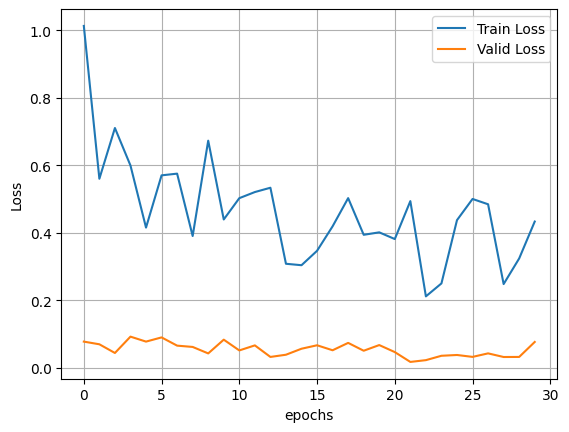

In [29]:
plt.plot( range(history.shape[0]), history["Train Loss"].values, label="Train Loss")
plt.plot( range(history.shape[0]), history["Valid Loss"].values, label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

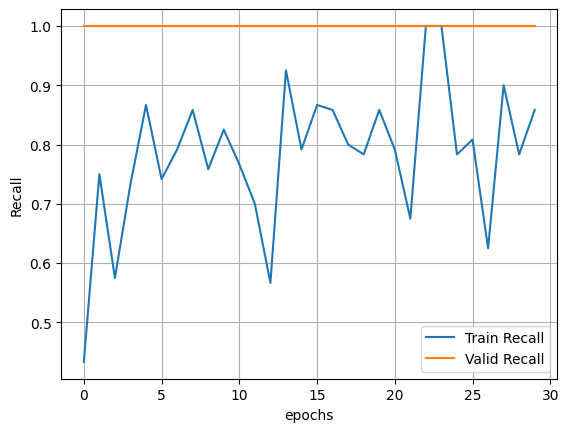

In [30]:
plt.plot( range(history.shape[0]), history["Train Recall"].values, label="Train Recall")
plt.plot( range(history.shape[0]), history["Valid Recall"].values, label="Valid Recall")
plt.xlabel("epochs")
plt.ylabel("Recall")
plt.grid()
plt.legend()
plt.show()

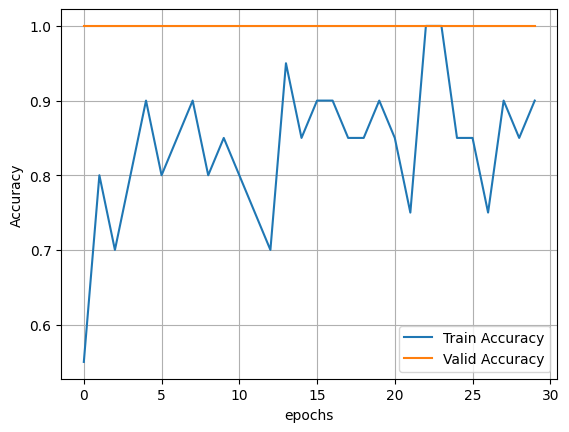

In [31]:
plt.plot( range(history.shape[0]), history["Train Accuracy"].values, label="Train Accuracy")
plt.plot( range(history.shape[0]), history["Valid Accuracy"].values, label="Valid Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

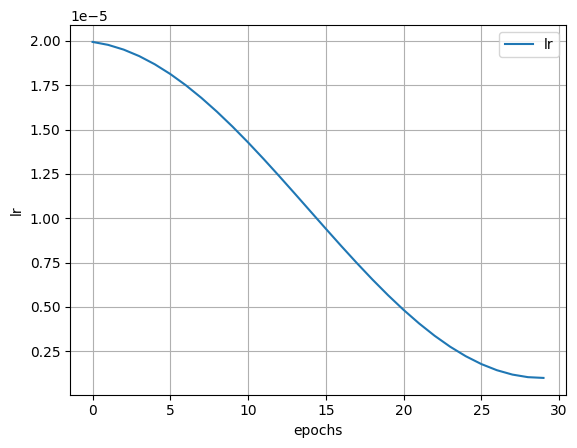

In [32]:
plt.plot( range(history.shape[0]), history["lr"].values, label="lr")
plt.xlabel("epochs")
plt.ylabel("lr")
plt.grid()
plt.legend()
plt.show()

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">oof</h1></span>

In [33]:
oof_dataset = UBCDataset(df, transforms=data_transforms["valid"])
oof_loader = DataLoader(oof_dataset, batch_size=CONFIG['valid_batch_size'], num_workers=2, shuffle=False, pin_memory=True)

In [34]:
total_preds_conf = []
total_preds_label = []
with torch.no_grad():
    bar = tqdm(enumerate(oof_loader), total=len(oof_loader))
    for step, data in bar:        
        images = data['image'].to(CONFIG["device"], dtype=torch.float)        
        batch_size = images.size(0)
        outputs = model(images)
        preds_conf = model.softmax(outputs)
        _, preds_label = torch.max(preds_conf, 1)
        total_preds_conf.append( preds_conf.detach().cpu().numpy() )
        total_preds_label.append( preds_label.detach().cpu().numpy() )
total_preds_conf = np.concatenate(total_preds_conf, axis=0)
total_preds_label = np.concatenate(total_preds_label).flatten()
total_preds_label2 = encoder.inverse_transform( total_preds_label )

100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


In [35]:
for i in range(total_preds_conf.shape[-1]):
    df[f"pred_conf_{i}"] = total_preds_conf[:, i]
df["pred_label"] = total_preds_label
df["pred_label_str"] = total_preds_label2
df.to_csv("oof.csv", index=False)

In [36]:
df

,index,sx,ex,sy,ey,image_id,label,ori_width,ori_height,crop_id,...,weight,label_str,kfold,pred_conf_0,pred_conf_1,pred_conf_2,pred_conf_3,pred_conf_4,pred_label,pred_label_str
0,2,0,2047,0,2047,91,2,2048,2048,0,...,0.999024,HGSC,0.0,4.167691e-02,0.049981,8.825904e-01,2.233208e-02,3.419822e-03,2,HGSC
1,57,0,2047,0,2047,4134,4,2048,2048,0,...,0.999024,MC,1.0,8.679222e-06,0.002564,4.206955e-06,1.052756e-05,9.974126e-01,4,MC
2,113,0,2047,0,2047,8280,2,2048,2048,0,...,0.999024,HGSC,2.0,8.973565e-05,0.179433,8.128363e-01,7.638097e-03,2.955198e-06,2,HGSC
3,123,0,2047,0,2047,9200,4,2048,2048,0,...,0.999024,MC,3.0,1.275659e-07,0.259579,8.936699e-05,1.550383e-05,7.403162e-01,4,MC
4,162,0,2047,0,2047,13568,3,2048,2048,0,...,0.999024,LGSC,0.0,2.651172e-04,0.003748,3.967853e-04,9.955167e-01,7.333915e-05,3,LGSC
5,219,0,2047,0,2047,17637,2,2048,2048,0,...,0.999024,HGSC,1.0,2.251701e-04,0.039439,3.242844e-01,6.360276e-01,2.406484e-05,3,LGSC
6,257,0,2047,0,2047,21020,4,2048,2048,0,...,0.999024,MC,3.0,2.755599e-02,0.097996,1.941649e-02,2.959710e-02,8.254343e-01,4,MC
7,347,0,2047,0,2047,29084,3,2048,2048,0,...,0.999024,LGSC,4.0,3.907586e-02,0.062649,1.244066e-01,7.716814e-01,2.186898e-03,3,LGSC
8,394,0,2047,0,2047,31594,1,2048,2048,0,...,0.999024,EC,4.0,7.451372e-04,0.960493,2.140990e-02,1.635854e-03,1.571634e-02,1,EC
9,425,0,2047,0,2047,35565,4,2048,2048,0,...,0.999024,MC,3.0,6.058827e-04,0.049455,5.656466e-03,1.562333e-03,9.427206e-01,4,MC


In [37]:
torch.save(model.state_dict(),"efficienetnetv2_s_tma.bin")